# HW2

## Basic moves

In [1]:
import pandas as pd
import torch

torch.manual_seed(42) # set random seed for reproducibility
df = pd.read_csv('train.txt', sep='\t', names=['item', 'category'])

In [2]:
# Convert text labels to integer ids

labels = df['category'].unique()
id2label = {idx: label for idx, label in enumerate(labels)}
label2id = {label: idx for idx, label in enumerate(labels)}

In [3]:
from sklearn.model_selection import train_test_split
import re

df['category'] = df['category'].apply(lambda cat: label2id[cat]) # applying converting
df['item'] = df['item'].apply(lambda x: re.sub('\d+', ' NUMBER ', x))
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42) # splitting to train and validate data


### Let's see the distribution of categories

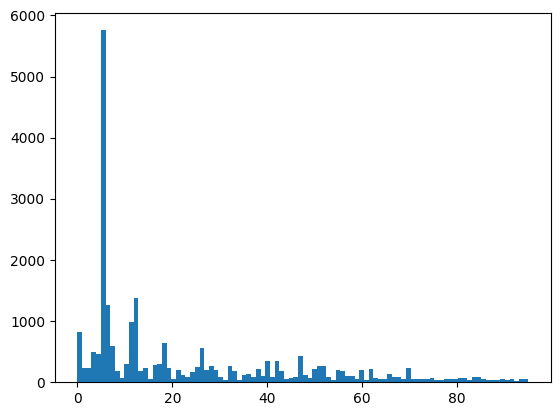

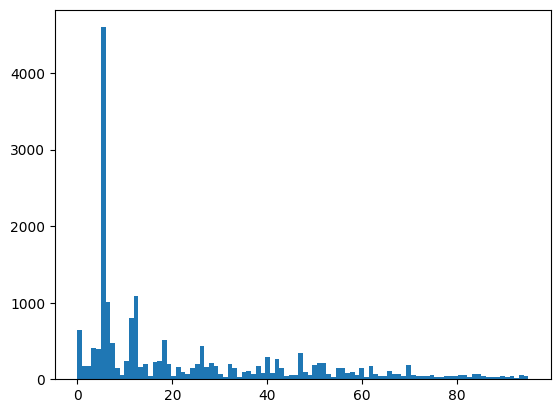

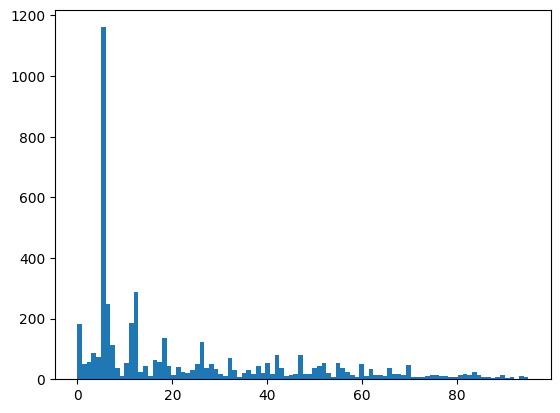

In [4]:
from matplotlib import pyplot as plt

plt.hist(df['category'], bins=len(labels))
plt.show()

plt.hist(df_train['category'], bins=len(labels))
plt.show()

plt.hist(df_test['category'], bins=len(labels))
plt.show()

In [5]:
df['category'].groupby(df['category']).count().sort_values(ascending=False)

category
5     5757
12    1378
6     1257
11     985
0      827
      ... 
89      39
77      37
88      34
91      34
93      13
Name: category, Length: 96, dtype: int64

In [6]:
large_cat = df['category'].groupby(df['category']).count().argmax() #the most frequent category


In [7]:
df[df['category'] == large_cat].head(3)

,item,category
5,Соединение быстроразъемное HS-SS-E- NUMBER,5
9,Ось ч.Э- NUMBER . NUMBER . NUMBER - NUMBER,5
11,Подшипник NUMBER АМНК ( NUMBER АСМW NUMBER ),5


Hilarious category which includes existing categories, but still needed for submit as it is, because of the high risk of loosing data, which can be seen only as this category

In [8]:
len(df[df['category'] == large_cat])/len(df)

0.24014516330872232

In [9]:
df_train.head()

,item,category
921,Соплодержатель к распылит окрасоч GA NUMBER,16
5325,Кольцо стопорное В NUMBER ГОСТ NUMBER (DIN NU...,12
4328,Клапан M- NUMBER SED NUMBER CK NUMBER X/ NUMB...,5
1470,Модуль NUMBER GK NUMBER - NUMBER GA NUMBER S...,5
1749,Датчик перемещения PT NUMBER - NUMBER - NUMBER...,60


## Training models

In [10]:
from bert_classifier import BertClassifier # using custom Classifier class 

# Use pretrained model and tokenizer for classification
classifier = BertClassifier(
        model_path='cointegrated/rubert-tiny2',
        tokenizer_path='cointegrated/rubert-tiny2',
        n_classes=len(labels),
        epochs=256,
        model_save_path='bert1.pt',
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
classifier.preparation(
        X_train=list(df_train['item']),
        y_train=list(df_train['category']),
        X_valid=list(df_test['item']),
        y_valid=list(df_test['category']),
    )

Let's see base predicts without training  

In [12]:
from sklearn.metrics import accuracy_score

df['no_training'] = df['item'].apply(lambda x: int(classifier.predict(x)))
accuracy_score(df['category'], df['no_training'])

0.0049222041463312894

just awful. Let's train it

In [13]:
classifier.train(early_stop=3)

Epoch 1/256
Train loss 1.9099052333831787 accuracy 0.5475023464386276
Val loss 1.30373459537824 accuracy 0.6571428571428571
----------
Epoch 2/256
Train loss 1.0819319984316826 accuracy 0.6988737094587548
Val loss 1.1829510720570882 accuracy 0.6969760166840459
----------
Epoch 3/256
Train loss 0.8507977289954821 accuracy 0.7549796641985609
Val loss 1.1092909117539724 accuracy 0.7261730969760166
----------
Epoch 4/256
Train loss 0.707953677016 accuracy 0.7871519449369069
Val loss 1.0819031123320262 accuracy 0.732638164754953
----------
Epoch 5/256
Train loss 0.6153337470442056 accuracy 0.8125977682761497
Val loss 1.1088175561030706 accuracy 0.7357664233576642
----------
Epoch 6/256
Train loss 0.573435183595866 accuracy 0.8209928042548754
Val loss 1.1279470419883728 accuracy 0.7386861313868613
----------
Epoch 7/256
Train loss 0.5602564258873463 accuracy 0.829127124830535
Val loss 1.1616619263092678 accuracy 0.745985401459854
----------
Epoch 8/256
Train loss 0.5156915458540122 accuracy 

## lets compare it with previous version of rubert-tiny


In [14]:
classifier2 = BertClassifier(
        model_path='cointegrated/rubert-tiny',
        tokenizer_path='cointegrated/rubert-tiny',
        n_classes=len(labels),
        epochs=256,
        model_save_path='bert2.pt',
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
classifier2.preparation(
        X_train=list(df_train['item']),
        y_train=list(df_train['category']),
        X_valid=list(df_test['item']),
        y_valid=list(df_test['category']),
    )

In [16]:
classifier2.train(early_stop=3)

Epoch 1/256
Train loss 2.0683117437362672 accuracy 0.5125664824277818
Val loss 1.403129076162974 accuracy 0.6356621480709072
----------
Epoch 2/256
Train loss 1.2884937280913193 accuracy 0.6513713630201272
Val loss 1.201163340806961 accuracy 0.6740354535974974
----------
Epoch 3/256
Train loss 1.0631961958607037 accuracy 0.7039315882782354
Val loss 1.1294529781738918 accuracy 0.7013555787278415
----------
Epoch 4/256
Train loss 0.9153222834567228 accuracy 0.7379810199186568
Val loss 1.1457709262768427 accuracy 0.716162669447341
----------
Epoch 5/256
Train loss 0.8242152191698551 accuracy 0.7577953905516738
Val loss 1.0971832011143368 accuracy 0.7220020855057351
----------
Epoch 6/256
Train loss 0.7412665810684363 accuracy 0.7765147564918136
Val loss 1.1214504302541415 accuracy 0.7176225234619396
----------
Epoch 7/256


KeyboardInterrupt: 

## Submitting

In [17]:
to_submit = pd.read_csv('test.txt', sep='\t', names=['item'])
to_submit['item'] = to_submit['item'].apply(lambda x: re.sub('\d+', ' NUMBER ', x))
to_submit['category'] = to_submit['item'].apply(lambda x: id2label[classifier.predict(x)])
to_submit.to_csv('submit.txt', index=False, sep='\t', header=False)
to_submit

,item,category
0,Подшипник NUMBER ( NUMBER ),Подшипники
1,Винт NUMBER х NUMBER ГОСТ NUMBER - NUMBER (D...,Метизы
2,Пускатель ПМ ГОСТО NUMBER - NUMBER - NUMBER ...,Запчасти
3,Образец станд Ш NUMBER концентрат плавико,РеактивыХимич.
4,Насос A NUMBER VG NUMBER EP NUMBER DT NUMBER /...,Насосы
...,...,...
2341,Втулка ч. NUMBER - NUMBER . NUMBER,Запчасти
2342,Фильтроэлемент NUMBER R NUMBER BN NUMBER HC,Запчасти
2343,Пила цепная электр руч UC NUMBER А Makita,Инстр. электрический
2344,Картридж Canon PFI- NUMBER C голубой NUMBER мл,ВычОргТехн и З/Ч


## Conclusion

For this task, I've used bert-based model and tokenizer for text classification. Also may be used gradient boosting and random forests but they need more time for text preparation. In my case the base pretrained rubert for classification is very bad escpecially in difference with trained version.In the end I've got model with accuracy of 0.76 on validation set, so it's can be used in the production.

Also I've noticed that rubert-tiny2 is more efficient and better than rubert-tiny, as it trained better for the same time.